<a href="https://colab.research.google.com/github/hillasch/SPICE-model/blob/hilla/transcreation_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup & Dependency Management

This section ensures a clean and reproducible environment by explicitly
installing compatible versions of all required libraries.

We first remove any preinstalled versions that may cause conflicts,
and then install pinned versions that were tested with this project.


In [3]:
# Remove preinstalled packages to avoid version conflicts
!pip -q uninstall -y diffusers transformers tokenizers accelerate
# Install pinned versions for reproducibility and stability
!pip -q install --no-cache-dir \
  "transformers==4.50.0" \
  "tokenizers>=0.20.0" \
  "accelerate>=0.34.0" \
  "diffusers==0.29.2" \
  "sentence-transformers==2.7.0" \
  "safetensors>=0.4.5"

print("✅ Install done. Runtime → Restart session (not run all)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 158.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 387.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 363.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 195.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 419.0 MB/s eta 0:00:00
✅ Install done. Runtime → Restart session (not run all)


> Important  
> After installation, **restart the runtime** before continuing.
> This ensures that all libraries are correctly loaded with the updated versions.


###  Repository Setup & Version Control

In this section we mount Google Drive and clone the project repository.
The repository is checked out to a specific working branch to ensure
consistency with the current experiment and codebase state.


In [1]:
from google.colab import drive
from pathlib import Path

# Mount Google Drive for persistent storage
drive.mount("/content/drive")
# Move to Colab working directory
%cd /content
# Remove any existing local copy to ensure a clean clone
!rm -rf SPICE-model
# Clone the project repository
!git clone https://github.com/hillasch/SPICE-model.git
# Enter the repository directory
%cd /content/SPICE-model
# Switch to the dedicated working branch
!git checkout hilla
# Pull the latest updates from the remote branch
!git pull

print("CWD:", Path.cwd())


Mounted at /content/drive
/content
Cloning into 'SPICE-model'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 78 (delta 5), reused 11 (delta 3), pack-reused 63 (from 1)
Receiving objects: 100% (78/78), 43.97 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/SPICE-model
Branch 'hilla' set up to track remote branch 'hilla' from 'origin'.
Switched to a new branch 'hilla'
Already up to date.
CWD: /content/SPICE-model


### TAESD Setup
This section downloads and loads the TAESD autoencoder, which is used to
encode and decode images into a compact latent space.

TAESD provides a fast and lightweight alternative to full VAE models,
making it suitable for iterative latent optimization and experimentation.


In [10]:
# Ensure we are working from the main content directory
%cd /content
# Download TAESD implementation and pretrained weights
# These files are fetched directly from the official repository
!wget -q -O taesd.py https://raw.githubusercontent.com/madebyollin/taesd/main/taesd.py
!wget -q -O taesd_encoder.pth https://raw.githubusercontent.com/madebyollin/taesd/main/taesd_encoder.pth
!wget -q -O taesd_decoder.pth https://raw.githubusercontent.com/madebyollin/taesd/main/taesd_decoder.pth
# Add current directory to Python path so taesd.py can be imported
import sys, torch
sys.path.insert(0, "/content")

# Import TAESD model
from taesd import TAESD
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize TAESD and set to evaluation mode
taesd = TAESD().to(device).eval()

print("✅ TAESD loaded on", device)


/content
✅ TAESD loaded on cuda


###  Core Imports & Device Setup

This section centralizes all core library imports and sets up the computation
device. Models are imported here but instantiated only once to avoid redundancy.


In [1]:
import io
import os
import pickle
import sys
import zipfile
import textwrap
from pathlib import Path

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from PIL import Image, ImageDraw, ImageFont

from sentence_transformers import SentenceTransformer, util
from diffusers import StableDiffusionImg2ImgPipeline

# TAESD implementation is already available in /content/taesd.py
sys.path.insert(0, "/content")
from taesd import TAESD

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Imports OK, device set to", device)


Imports OK, device set to cuda


### CLIP-Based Image Retrieval (Unsplash-25k)

This section loads a precomputed image database (Unsplash-25k) along with
its CLIP embeddings, enabling fast semantic retrieval.

Given a text prompt, we embed the prompt with CLIP and retrieve the most
semantically similar image from the dataset to serve as a proxy target.


In [2]:
# Local directory to store downloaded assets (cached across runs if Drive is used)
ASSETS_DIR = Path("/content/assets_unsplash")
ASSETS_DIR.mkdir(parents=True, exist_ok=True)

# Expected asset files: image zip + precomputed embeddings
PHOTO_FILENAME = ASSETS_DIR / "unsplash-25k-photos.zip"
EMB_FILENAME   = ASSETS_DIR / "unsplash-25k-photos-embeddings.pkl"
# Load the CLIP text encoder this model is used to embed the prompt for semantic search
SEARCH_MODEL = SentenceTransformer("clip-ViT-B-32")


def _ensure_unsplash_data():
    """
    Download Unsplash-25k assets if they are missing locally.
    Using precomputed image embeddings allows very fast retrieval.
    """
    if not PHOTO_FILENAME.exists():
        util.http_get("http://sbert.net/datasets/unsplash-25k-photos.zip", str(PHOTO_FILENAME))
    if not EMB_FILENAME.exists():
        util.http_get("http://sbert.net/datasets/unsplash-25k-photos-embeddings.pkl", str(EMB_FILENAME))

def _load_search_assets():

    _ensure_unsplash_data()
    photo_zip = zipfile.ZipFile(PHOTO_FILENAME, "r")
    zip_image_names = set(photo_zip.namelist())
    with open(EMB_FILENAME, "rb") as f:
        img_names, img_emb = pickle.load(f)
    print("Images:", len(img_names))
    return photo_zip, zip_image_names, img_names, img_emb

PHOTO_ZIP, ZIP_IMAGE_NAMES, IMG_NAMES, IMG_EMB = _load_search_assets()

def load_image_bytes(image_name: str) -> bytes:
    """
    Fetch raw bytes for an image from the zip file (no extraction needed).
    """
    if image_name in ZIP_IMAGE_NAMES:
        return PHOTO_ZIP.read(image_name)
    raise FileNotFoundError(image_name)

def search_top_image(prompt: str):
    """
    Given a text prompt:
      1) Embed prompt with CLIP
      2) Perform semantic search over precomputed image embeddings
      3) Load and return the best-matching image

    Returns:
      (image_name, similarity_score, PIL_image)
    """
    q = SEARCH_MODEL.encode([prompt], convert_to_tensor=True, show_progress_bar=False)
    hit = util.semantic_search(q, IMG_EMB, top_k=1)[0][0]
    name = IMG_NAMES[hit["corpus_id"]]
    img = Image.open(io.BytesIO(load_image_bytes(name))).convert("RGB")
    return name, float(hit["score"]), img


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Images: 24996


###  Image - Latent Space Utilities (TAESD)

This section defines helper functions for converting images between
pixel space (PIL / tensors) and the TAESD latent space.

These utilities are used throughout the pipeline for encoding source
images, performing latent operations, and decoding results back to image space.


In [3]:
# Target image resolution used throughout the pipeline
IMAGE_SIZE = 512

def preprocess_pil(image, size=IMAGE_SIZE):
    """
    Preprocess a PIL image:
      - Ensure RGB format
      - Resize to a fixed square resolution
    """
    image = image.convert("RGB")
    return TF.resize(image, [size, size])

def encode_image_pil(image):
    """
    image: PIL.Image
    returns:
      x : torch tensor [1,3,512,512]
      z : TAESD latent [1,4,64,64]
    """
    # Preprocess and convert image to tensor
    img = preprocess_pil(image)
    x = TF.to_tensor(img).unsqueeze(0).to(device)
    # Encode image into latent space
    with torch.no_grad():
        z = taesd.encoder(x)
    return x, z

def decode_latent(z):
    """
    z: TAESD latent [1,4,64,64]
    returns decoded image tensor [1,3,512,512]
    """
    # Decode latent and clamp values to valid image range
    with torch.no_grad():
        y = taesd.decoder(z).clamp(0, 1)
    return y


###  DINOv2 Visual Embeddings

This section loads a pretrained DINOv2 model, which is used to extract
high-level visual embeddings from images.

These embeddings serve as a semantic representation of images and are
later used to compute similarity-based losses in latent space.


In [13]:
from transformers import AutoImageProcessor, AutoModel
# Pretrained DINOv2 checkpoint
# "small" is chosen for efficiency
DINO_ID = "facebook/dinov2-small"

# Image preprocessing pipeline for DINOv2
dino_processor = AutoImageProcessor.from_pretrained(DINO_ID)

# Load DINOv2 model and move to selected device
dino_model = AutoModel.from_pretrained(DINO_ID).to(device)
dino_model.eval()

# Freeze all parameters
for p in dino_model.parameters():
    p.requires_grad_(False)

print("✅ DINOv2 loaded:", DINO_ID)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ DINOv2 loaded: facebook/dinov2-small


###  Semantic Midpoint Optimization in Latent Space (DINOv2)

This section implements the core optimization step:
we search for a latent representation whose decoded image has a DINOv2 embedding
close to the midpoint between two reference images (source + semantic target).

Key idea:
- Compute DINO embeddings for both images (frozen model).
- Define the target embedding as their midpoint.
- Optimize a latent variable so that the decoded image matches this target embedding.


In [4]:
import torch.nn.functional as F

def prepare_for_dino(image_tensor: torch.Tensor, processor, device):
    """
      Prepare an image tensor for DINOv2:
        - Resize to the expected input resolution
        - Normalize using processor mean/std

      Args:
        image_tensor: torch.Tensor [1, 3, H, W] in range [0,1]
      Returns:
        normalized tensor [1, 3, tgt_h, tgt_w]
    """
    size_cfg = processor.size
    if isinstance(size_cfg, dict):
        tgt = size_cfg.get("shortest_edge") or size_cfg.get("height") or 224
        tgt_h = tgt_w = int(tgt)
    else:
        tgt_h = tgt_w = int(size_cfg)

    # Resize using bicubic interpolation for smoother downsampling
    x = F.interpolate(image_tensor, size=(tgt_h, tgt_w), mode="bicubic", align_corners=False)

    # Normalize according to the processor configuration
    mean = torch.tensor(processor.image_mean, device=device, dtype=x.dtype).view(1, 3, 1, 1)
    std  = torch.tensor(processor.image_std,  device=device, dtype=x.dtype).view(1, 3, 1, 1)
    return (x - mean) / std

def embed_tensor_with_dino(image_tensor: torch.Tensor):
    """
    Extract a single DINOv2 embedding vector from an image tensor.

    Uses mean pooling over transformer tokens to get a global image descriptor.
    Returns:
      embedding: torch.Tensor [dim]
    """
    x = prepare_for_dino(image_tensor, dino_processor, device=image_tensor.device)
    out = dino_model(pixel_values=x)
    # mean pooling over tokens -> [dim]
    return out.last_hidden_state.mean(dim=1).squeeze(0)

def optimize_semantic_midpoint(
    image_a, image_b, latent_a, latent_b,
    steps=10, lr=0.1, grad_clip=1.0
):
    """
    Optimize a latent representation so that its decoded image embedding is close
    to the semantic midpoint between image_a and image_b (in DINOv2 space).

    Args:
      image_a, image_b: tensors [1,3,512,512] in [0,1]
      latent_a, latent_b: TAESD latents [1,4,64,64]
    Returns:
      final: decoded optimized image tensor [1,3,512,512]
      losses: list of float loss values per step
    """
    # target embedding: midpoint between source and target embeddings
    with torch.no_grad():
        emb_a = embed_tensor_with_dino(image_a)
        emb_b = embed_tensor_with_dino(image_b)
        target_emb = 0.5 * (emb_a + emb_b)

    latent_param = torch.nn.Parameter(0.5 * (latent_a + latent_b))
    opt = torch.optim.Adam([latent_param], lr=lr)

    losses = []
    for s in range(1, steps + 1):
        opt.zero_grad()

        decoded = taesd.decoder(latent_param).clamp(0,1)  # allow grad
        emb_hat = embed_tensor_with_dino(decoded)

        loss = F.mse_loss(emb_hat, target_emb)
        loss.backward()

        if grad_clip:
            torch.nn.utils.clip_grad_norm_([latent_param], grad_clip)

        opt.step()
        losses.append(float(loss.item()))

        if s == 1 or s % 5 == 0 or s == steps:
            print(f"[opt] step {s}/{steps} loss={loss.item():.6f}")

    final = taesd.decoder(latent_param.detach()).clamp(0,1)
    return final, losses


###  Diffusion Runtime Stabilization

This section re-installs a minimal and compatible set of diffusion-related
dependencies to avoid runtime conflicts.

In particular, optional acceleration libraries (e.g. `peft`, `xformers`)
are removed to ensure consistent behavior across environments.


In [8]:
# Remove optional acceleration libraries that may cause incompatibilities
# with the selected Diffusers / Transformers versions
!pip -q uninstall -y peft xformers

# Reinstall a clean, pinned set of core diffusion dependencies

!pip -q install --no-cache-dir --force-reinstall \
  "transformers==4.50.0" \
  "tokenizers>=0.20.0" \
  "accelerate>=0.34.0" \
  "diffusers==0.29.2" \
  "safetensors>=0.4.5"

print("✅ Removed peft/xformers and reinstalled core. Now Runtime → Restart session")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 265.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 329.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 151.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 262.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 245.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 298.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 281.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 295.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 238.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 218.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 311.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 143.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

> After reinstalling these packages, the runtime should be restarted
> before continuing to model initialization.

In [5]:
import transformers, diffusers, torch


###  Diffusion Pipeline Availability Check

This cell verifies that the Stable Diffusion img2img pipeline
is available and can be imported successfully after the environment setup.


In [6]:
from diffusers import StableDiffusionImg2ImgPipeline
# Sanity check: ensure img2img pipeline is accessible
print("✅ Img2Img import OK")


✅ Img2Img import OK


###  Diffusion-Based Coherence Refinement (Img2Img)

This section loads a Stable Diffusion img2img pipeline and defines a helper
function to refine intermediate images.

The goal is to project images back onto the manifold of natural images,
while preserving the semantic direction defined earlier in latent space.


In [7]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

SD_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SD_DTYPE  = torch.float16 if SD_DEVICE == "cuda" else torch.float32

# Load Stable Diffusion img2img pipeline
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=SD_DTYPE,
).to(SD_DEVICE)

# Enable attention slicing to reduce peak VRAM usage
pipe_img2img.enable_attention_slicing()

print("✅ SD Img2Img loaded on", SD_DEVICE, "| dtype:", SD_DTYPE)

def make_image_coherent(image, prompt, strength=0.6, guidance_scale=7.5, steps=35, seed=0):
    """
    Refine an image using Stable Diffusion img2img.

    Args:
      image (PIL.Image): input image to refine
      prompt (str): text prompt guiding the refinement
      strength (float): degree of deviation from the input image
      guidance_scale (float): classifier-free guidance strength
      steps (int): number of diffusion steps
      seed (int or None): random seed for reproducibility

    Returns:
      PIL.Image: refined, visually coherent image
    """
    g = torch.Generator(device=SD_DEVICE).manual_seed(int(seed)) if seed is not None else None
    out = pipe_img2img(
        prompt=str(prompt),
        image=image.convert("RGB"),
        strength=float(strength),
        guidance_scale=float(guidance_scale),
        num_inference_steps=int(steps),
        generator=g,
    )
    return out.images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ SD Img2Img loaded on cuda | dtype: torch.float16


###  End-to-End Batch Run

This section runs the full pipeline end-to-end on a reproducible random sample:
1. Load dataset metadata (CSV)
2. Sample N rows with a fixed seed (for reproducibility)
3. For each sample:
   - Retrieve a CLIP-based proxy target image
   - Encode source + target with TAESD
   - Optimize a latent midpoint using DINOv2 semantic loss
   - Refine the result using Stable Diffusion img2img
4. Save outputs + intermediate images and write a structured run log.

All outputs are written to a Drive folder to persist across sessions.


In [36]:
from pathlib import Path
import json, gc
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm

# CSV contains dataset metadata (paths + prompts + countries)
CSV_PATH = Path("/content/drive/MyDrive/transcreation_dataset/train_dataset.csv")

# Output directory for generated images + logs (persistent in Drive)
RUN_TAG = "five_run"
OUT_DIR = Path("/content/drive/MyDrive/transcreation_outputs") / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load dataset metadata
df = pd.read_csv(CSV_PATH)

# ---- Reproducible sampling ----
# We run on a random subset for quick iteration and stable comparisons across runs
N = 60
SEED = 42
sampled_indices = df.sample(n=N, random_state=SEED).index.tolist()

# Save sampled indices so the exact same subset can be reproduced later
with open(OUT_DIR / f"sampled_indices_{N}_seed{SEED}.json", "w") as f:
    json.dump(sampled_indices, f)

print(f"✅ sampled {N} indices (seed={SEED})")

# ---- Column names (match dataset schema) ----
SRC_COL = "src_local_path"
P2_COL  = "model_path_2"
SRC_CTRY_COL = "src_country"
TGT_CTRY_COL = "target_country"
PROMPT_COL   = "llm_edit"

# ---- Runtime knobs (T4-safe defaults) ----
# These settings balance quality vs. runtime on Colab T4
OPT_STEPS = 15
OPT_LR = 0.05
SD_STEPS = 35
SD_STRENGTH = 0.45
SD_GUIDANCE = 6.5

SAVE_INTERMEDIATE = True  # src / clip_target / mid / p2 / out

def clear_vram():
    """Best-effort VRAM cleanup between iterations (helps avoid OOM on T4)."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

results = []
fails = 0
SD_SUFFIX = ", realistic, high quality, sharp focus, natural lighting"
# ---- Main loop ----
for IDX in tqdm(sampled_indices):
    try:
        clear_vram()

        row = df.iloc[IDX]

        # Extract metadata
        src_country = str(row.get(SRC_CTRY_COL, ""))
        tgt_country = str(row.get(TGT_CTRY_COL, ""))
        prompt      = str(row.get(PROMPT_COL, "")).strip()

        # Extract paths
        src_path = Path(str(row.get(SRC_COL, "")))
        p2_path  = Path(str(row.get(P2_COL, ""))) if pd.notna(row.get(P2_COL, None)) else None

        # Skip invalid rows early (missing image or empty prompt)
        if (not src_path.exists()) or (not prompt):
            results.append((IDX, False, src_country, tgt_country, "", "", "missing src or empty llm_edit"))
            fails += 1
            continue

        # Load source image
        src_img = Image.open(src_path).convert("RGB")

        # Load Pipeline-2 output image if available (for side-by-side comparison)
        p2_img = None
        p2_exists = False
        if p2_path is not None and p2_path.exists():
            p2_img = Image.open(p2_path).convert("RGB")
            p2_exists = True

        # 1) CLIP search target (proxy semantic target)
        clip_name, clip_score, tgt_img = search_top_image(prompt)

        # 2) TAESD encode
        x_src, z_src = encode_image_pil(src_img)
        x_tgt, z_tgt = encode_image_pil(tgt_img)

        # 3) OPT (MSE in DINO space)
        decoded_opt, losses = optimize_semantic_midpoint(
            image_a=x_src,
            image_b=x_tgt,
            latent_a=z_src,
            latent_b=z_tgt,
            steps=OPT_STEPS,
            lr=OPT_LR,
            grad_clip=1.0
        )
        mid_pil = TF.to_pil_image(decoded_opt[0].cpu())

        # 4) SD img2img refine
        sd_prompt = prompt + SD_SUFFIX
        out_pil = make_image_coherent(
            image=mid_pil,
            prompt=sd_prompt,
            strength=SD_STRENGTH,
            guidance_scale=SD_GUIDANCE,
            steps=SD_STEPS,
            seed=100 + int(IDX),
        )

        # ---- save ----
        out_pil.save(OUT_DIR / f"{IDX:06d}_ours.png")

        # Save smaller thumbnails for quick inspection
        if SAVE_INTERMEDIATE:
            src_img.resize((256,256)).save(OUT_DIR / f"{IDX:06d}_src.png")
            tgt_img.resize((256,256)).save(OUT_DIR / f"{IDX:06d}_clip_target.png")
            mid_pil.resize((256,256)).save(OUT_DIR / f"{IDX:06d}_taesd_mid.png")
            if p2_img is not None:
                p2_img.resize((256,256)).save(OUT_DIR / f"{IDX:06d}_p2.png")

        # Append success row to log
        results.append((
            IDX, True,
            src_country, tgt_country,
            clip_name, float(clip_score),
            f"ok loss={losses[-1]:.6f} p2={'yes' if p2_exists else 'no'}"
        ))

    except Exception as e:
        results.append((IDX, False, "", "", "", "", f"{type(e).__name__}: {e}"))
        fails += 1

print("✅ Done. fails:", fails, "out of", len(results))

log_df = pd.DataFrame(results, columns=[
    "idx", "success",
    "src_country", "target_country",
    "clip_image_name", "clip_score",
    "msg"
])
log_path = OUT_DIR / f"run_log_{N}_seed{SEED}_withP2.csv"
log_df.to_csv(log_path, index=False)
print("✅ log saved:", log_path)

# also save a lightweight metadata table with the prompt (optional)
meta_df = df.loc[sampled_indices, [SRC_CTRY_COL, TGT_CTRY_COL, PROMPT_COL, SRC_COL, P2_COL]].copy()
meta_df.insert(0, "idx", meta_df.index)
meta_df.to_csv(OUT_DIR / f"meta_{N}_seed{SEED}.csv", index=False)
print("✅ meta saved:", OUT_DIR / f"meta_{N}_seed{SEED}.csv")

log_df.head(10)


✅ sampled 60 indices (seed=42)


  0%|          | 0/60 [00:00<?, ?it/s]

[opt] step 1/15 loss=1.486719
[opt] step 5/15 loss=0.468517
[opt] step 10/15 loss=0.243859
[opt] step 15/15 loss=0.157777


  0%|          | 0/15 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:06<05:56,  6.05s/it]

[opt] step 1/15 loss=1.325750
[opt] step 5/15 loss=0.340442
[opt] step 10/15 loss=0.186543
[opt] step 15/15 loss=0.119216


  0%|          | 0/15 [00:00<?, ?it/s]

  3%|▎         | 2/60 [00:12<05:57,  6.16s/it]

[opt] step 1/15 loss=1.810791
[opt] step 5/15 loss=0.420507
[opt] step 10/15 loss=0.240720
[opt] step 15/15 loss=0.162840


  0%|          | 0/15 [00:00<?, ?it/s]

  5%|▌         | 3/60 [00:18<05:45,  6.07s/it]

[opt] step 1/15 loss=1.916638
[opt] step 5/15 loss=0.499836
[opt] step 10/15 loss=0.253405
[opt] step 15/15 loss=0.172105


  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 4/60 [00:24<05:39,  6.07s/it]

[opt] step 1/15 loss=0.815941
[opt] step 5/15 loss=0.247715
[opt] step 10/15 loss=0.130866
[opt] step 15/15 loss=0.084279


  0%|          | 0/15 [00:00<?, ?it/s]

  8%|▊         | 5/60 [00:30<05:32,  6.05s/it]

[opt] step 1/15 loss=1.375675
[opt] step 5/15 loss=0.235516
[opt] step 10/15 loss=0.115540
[opt] step 15/15 loss=0.061526


  0%|          | 0/15 [00:00<?, ?it/s]

 10%|█         | 6/60 [00:36<05:26,  6.04s/it]

[opt] step 1/15 loss=1.280405
[opt] step 5/15 loss=0.214443
[opt] step 10/15 loss=0.103426
[opt] step 15/15 loss=0.057846


  0%|          | 0/15 [00:00<?, ?it/s]

 12%|█▏        | 7/60 [00:42<05:21,  6.07s/it]

[opt] step 1/15 loss=1.365437
[opt] step 5/15 loss=0.334786
[opt] step 10/15 loss=0.154924
[opt] step 15/15 loss=0.090417


  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 8/60 [00:48<05:19,  6.15s/it]

[opt] step 1/15 loss=1.400804
[opt] step 5/15 loss=0.267971
[opt] step 10/15 loss=0.127525
[opt] step 15/15 loss=0.083433


  0%|          | 0/15 [00:00<?, ?it/s]

 15%|█▌        | 9/60 [00:54<05:12,  6.13s/it]

[opt] step 1/15 loss=0.810773
[opt] step 5/15 loss=0.275396
[opt] step 10/15 loss=0.147071
[opt] step 15/15 loss=0.096245


  0%|          | 0/15 [00:00<?, ?it/s]

 17%|█▋        | 10/60 [01:00<05:05,  6.12s/it]

[opt] step 1/15 loss=1.513088
[opt] step 5/15 loss=0.324769
[opt] step 10/15 loss=0.166043
[opt] step 15/15 loss=0.105758


  0%|          | 0/15 [00:00<?, ?it/s]

 18%|█▊        | 11/60 [01:07<05:03,  6.19s/it]

[opt] step 1/15 loss=1.747763
[opt] step 5/15 loss=0.313356
[opt] step 10/15 loss=0.147739
[opt] step 15/15 loss=0.094384


  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 12/60 [01:13<04:57,  6.20s/it]

[opt] step 1/15 loss=1.603753
[opt] step 5/15 loss=0.415446
[opt] step 10/15 loss=0.184222
[opt] step 15/15 loss=0.104971


  0%|          | 0/15 [00:00<?, ?it/s]

 22%|██▏       | 13/60 [01:19<04:51,  6.21s/it]

[opt] step 1/15 loss=1.214923
[opt] step 5/15 loss=0.335292
[opt] step 10/15 loss=0.168865
[opt] step 15/15 loss=0.106697


  0%|          | 0/15 [00:00<?, ?it/s]

 23%|██▎       | 14/60 [01:26<04:47,  6.25s/it]

[opt] step 1/15 loss=1.269834
[opt] step 5/15 loss=0.287553
[opt] step 10/15 loss=0.124851
[opt] step 15/15 loss=0.074231


  0%|          | 0/15 [00:00<?, ?it/s]

 25%|██▌       | 15/60 [01:32<04:43,  6.30s/it]

[opt] step 1/15 loss=1.743188
[opt] step 5/15 loss=0.503306
[opt] step 10/15 loss=0.362025
[opt] step 15/15 loss=0.216367


  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 16/60 [01:38<04:35,  6.25s/it]

[opt] step 1/15 loss=1.416836
[opt] step 5/15 loss=0.383550
[opt] step 10/15 loss=0.194583
[opt] step 15/15 loss=0.118978


  0%|          | 0/15 [00:00<?, ?it/s]

 28%|██▊       | 17/60 [01:45<04:35,  6.41s/it]

[opt] step 1/15 loss=1.585375
[opt] step 5/15 loss=0.489801
[opt] step 10/15 loss=0.302135
[opt] step 15/15 loss=0.212800


  0%|          | 0/15 [00:00<?, ?it/s]

 30%|███       | 18/60 [01:51<04:26,  6.35s/it]

[opt] step 1/15 loss=1.084669
[opt] step 5/15 loss=0.328880
[opt] step 10/15 loss=0.169348
[opt] step 15/15 loss=0.109245


  0%|          | 0/15 [00:00<?, ?it/s]

 32%|███▏      | 19/60 [01:58<04:20,  6.36s/it]

[opt] step 1/15 loss=0.958105
[opt] step 5/15 loss=0.257483
[opt] step 10/15 loss=0.138480
[opt] step 15/15 loss=0.092518


  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 20/60 [02:04<04:13,  6.33s/it]

[opt] step 1/15 loss=1.507823
[opt] step 5/15 loss=0.218288
[opt] step 10/15 loss=0.107405
[opt] step 15/15 loss=0.068320


  0%|          | 0/15 [00:00<?, ?it/s]

 35%|███▌      | 21/60 [02:10<04:08,  6.37s/it]

[opt] step 1/15 loss=0.787548
[opt] step 5/15 loss=0.155847
[opt] step 10/15 loss=0.065315
[opt] step 15/15 loss=0.038733


  0%|          | 0/15 [00:00<?, ?it/s]

 37%|███▋      | 22/60 [02:16<04:00,  6.32s/it]

[opt] step 1/15 loss=1.313199
[opt] step 5/15 loss=0.155110
[opt] step 10/15 loss=0.079168
[opt] step 15/15 loss=0.045168


  0%|          | 0/15 [00:00<?, ?it/s]

 38%|███▊      | 23/60 [02:23<03:59,  6.46s/it]

[opt] step 1/15 loss=1.485297
[opt] step 5/15 loss=0.303288
[opt] step 10/15 loss=0.118762
[opt] step 15/15 loss=0.067392


  0%|          | 0/15 [00:00<?, ?it/s]

 40%|████      | 24/60 [02:29<03:49,  6.38s/it]

[opt] step 1/15 loss=1.227938
[opt] step 5/15 loss=0.486366
[opt] step 10/15 loss=0.287719
[opt] step 15/15 loss=0.186618


  0%|          | 0/15 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
 42%|████▏     | 25/60 [02:36<03:41,  6.33s/it]

[opt] step 1/15 loss=1.595224
[opt] step 5/15 loss=0.336776
[opt] step 10/15 loss=0.165474
[opt] step 15/15 loss=0.105768


  0%|          | 0/15 [00:00<?, ?it/s]

 43%|████▎     | 26/60 [02:42<03:33,  6.29s/it]

[opt] step 1/15 loss=1.465465
[opt] step 5/15 loss=0.430617
[opt] step 10/15 loss=0.264308
[opt] step 15/15 loss=0.181921


  0%|          | 0/15 [00:00<?, ?it/s]

 45%|████▌     | 27/60 [02:48<03:28,  6.33s/it]

[opt] step 1/15 loss=1.543501
[opt] step 5/15 loss=0.324123
[opt] step 10/15 loss=0.190497
[opt] step 15/15 loss=0.128968


  0%|          | 0/15 [00:00<?, ?it/s]

 47%|████▋     | 28/60 [02:55<03:21,  6.30s/it]

[opt] step 1/15 loss=1.720066
[opt] step 5/15 loss=0.560771
[opt] step 10/15 loss=0.330153
[opt] step 15/15 loss=0.221120


  0%|          | 0/15 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
 48%|████▊     | 29/60 [03:01<03:14,  6.26s/it]

[opt] step 1/15 loss=1.143394
[opt] step 5/15 loss=0.348356
[opt] step 10/15 loss=0.195924
[opt] step 15/15 loss=0.122398


  0%|          | 0/15 [00:00<?, ?it/s]

 50%|█████     | 30/60 [03:07<03:07,  6.25s/it]

[opt] step 1/15 loss=1.590426
[opt] step 5/15 loss=0.446604
[opt] step 10/15 loss=0.283789
[opt] step 15/15 loss=0.197021


  0%|          | 0/15 [00:00<?, ?it/s]

 52%|█████▏    | 31/60 [03:13<03:01,  6.27s/it]

[opt] step 1/15 loss=1.338371
[opt] step 5/15 loss=0.328768
[opt] step 10/15 loss=0.163932
[opt] step 15/15 loss=0.100635


  0%|          | 0/15 [00:00<?, ?it/s]

 53%|█████▎    | 32/60 [03:20<02:55,  6.27s/it]

[opt] step 1/15 loss=1.451628
[opt] step 5/15 loss=0.216784
[opt] step 10/15 loss=0.110542
[opt] step 15/15 loss=0.065207


  0%|          | 0/15 [00:00<?, ?it/s]

 55%|█████▌    | 33/60 [03:26<02:51,  6.37s/it]

[opt] step 1/15 loss=1.481023
[opt] step 5/15 loss=0.452121
[opt] step 10/15 loss=0.239072
[opt] step 15/15 loss=0.157542


  0%|          | 0/15 [00:00<?, ?it/s]

 57%|█████▋    | 34/60 [03:33<02:46,  6.39s/it]

[opt] step 1/15 loss=1.687976
[opt] step 5/15 loss=0.472091
[opt] step 10/15 loss=0.251914
[opt] step 15/15 loss=0.152383


  0%|          | 0/15 [00:00<?, ?it/s]

 58%|█████▊    | 35/60 [03:39<02:39,  6.37s/it]

[opt] step 1/15 loss=0.914950
[opt] step 5/15 loss=0.236656
[opt] step 10/15 loss=0.122779
[opt] step 15/15 loss=0.078827


  0%|          | 0/15 [00:00<?, ?it/s]

 60%|██████    | 36/60 [03:45<02:32,  6.35s/it]

[opt] step 1/15 loss=1.473503
[opt] step 5/15 loss=0.319552
[opt] step 10/15 loss=0.161757
[opt] step 15/15 loss=0.096685


  0%|          | 0/15 [00:00<?, ?it/s]

 62%|██████▏   | 37/60 [03:52<02:26,  6.35s/it]

[opt] step 1/15 loss=0.916645
[opt] step 5/15 loss=0.209679
[opt] step 10/15 loss=0.097123
[opt] step 15/15 loss=0.056387


  0%|          | 0/15 [00:00<?, ?it/s]

 63%|██████▎   | 38/60 [03:58<02:19,  6.34s/it]

[opt] step 1/15 loss=0.851207
[opt] step 5/15 loss=0.312960
[opt] step 10/15 loss=0.163616
[opt] step 15/15 loss=0.107333


  0%|          | 0/15 [00:00<?, ?it/s]

 65%|██████▌   | 39/60 [04:04<02:12,  6.33s/it]

[opt] step 1/15 loss=1.592868
[opt] step 5/15 loss=0.451394
[opt] step 10/15 loss=0.250040
[opt] step 15/15 loss=0.160736


  0%|          | 0/15 [00:00<?, ?it/s]

 67%|██████▋   | 40/60 [04:11<02:07,  6.36s/it]

[opt] step 1/15 loss=1.278198
[opt] step 5/15 loss=0.400181
[opt] step 10/15 loss=0.208690
[opt] step 15/15 loss=0.127346


  0%|          | 0/15 [00:00<?, ?it/s]

 68%|██████▊   | 41/60 [04:17<02:01,  6.40s/it]

[opt] step 1/15 loss=1.343105
[opt] step 5/15 loss=0.247100
[opt] step 10/15 loss=0.128693
[opt] step 15/15 loss=0.077885


  0%|          | 0/15 [00:00<?, ?it/s]

 70%|███████   | 42/60 [04:24<01:55,  6.42s/it]

[opt] step 1/15 loss=1.448067
[opt] step 5/15 loss=0.306143
[opt] step 10/15 loss=0.141974
[opt] step 15/15 loss=0.093404


  0%|          | 0/15 [00:00<?, ?it/s]

 72%|███████▏  | 43/60 [04:30<01:49,  6.44s/it]

[opt] step 1/15 loss=1.060236
[opt] step 5/15 loss=0.328913
[opt] step 10/15 loss=0.168795
[opt] step 15/15 loss=0.106076


  0%|          | 0/15 [00:00<?, ?it/s]

 73%|███████▎  | 44/60 [04:37<01:45,  6.57s/it]

[opt] step 1/15 loss=1.033143
[opt] step 5/15 loss=0.243500
[opt] step 10/15 loss=0.133659
[opt] step 15/15 loss=0.084013


  0%|          | 0/15 [00:00<?, ?it/s]

 75%|███████▌  | 45/60 [04:43<01:37,  6.53s/it]

[opt] step 1/15 loss=1.437768
[opt] step 5/15 loss=0.440354
[opt] step 10/15 loss=0.241560
[opt] step 15/15 loss=0.161476


  0%|          | 0/15 [00:00<?, ?it/s]

 77%|███████▋  | 46/60 [04:50<01:31,  6.51s/it]

[opt] step 1/15 loss=0.771021
[opt] step 5/15 loss=0.310327
[opt] step 10/15 loss=0.184481
[opt] step 15/15 loss=0.122072


  0%|          | 0/15 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
 78%|███████▊  | 47/60 [04:56<01:23,  6.42s/it]

[opt] step 1/15 loss=1.382210
[opt] step 5/15 loss=0.849371
[opt] step 10/15 loss=0.504300
[opt] step 15/15 loss=0.378199


  0%|          | 0/15 [00:00<?, ?it/s]

 80%|████████  | 48/60 [05:04<01:22,  6.84s/it]

[opt] step 1/15 loss=1.535340
[opt] step 5/15 loss=0.306579
[opt] step 10/15 loss=0.145026
[opt] step 15/15 loss=0.084037


  0%|          | 0/15 [00:00<?, ?it/s]

 82%|████████▏ | 49/60 [05:10<01:13,  6.70s/it]

[opt] step 1/15 loss=1.611216
[opt] step 5/15 loss=0.459096
[opt] step 10/15 loss=0.239537
[opt] step 15/15 loss=0.148074


  0%|          | 0/15 [00:00<?, ?it/s]

 83%|████████▎ | 50/60 [05:17<01:06,  6.64s/it]

[opt] step 1/15 loss=1.233917
[opt] step 5/15 loss=0.246329
[opt] step 10/15 loss=0.123347
[opt] step 15/15 loss=0.074915


  0%|          | 0/15 [00:00<?, ?it/s]

 85%|████████▌ | 51/60 [05:23<00:59,  6.59s/it]

[opt] step 1/15 loss=1.250956
[opt] step 5/15 loss=0.254957
[opt] step 10/15 loss=0.135947
[opt] step 15/15 loss=0.089912


  0%|          | 0/15 [00:00<?, ?it/s]

 87%|████████▋ | 52/60 [05:30<00:52,  6.55s/it]

[opt] step 1/15 loss=1.777474
[opt] step 5/15 loss=0.297234
[opt] step 10/15 loss=0.143874
[opt] step 15/15 loss=0.084088


  0%|          | 0/15 [00:00<?, ?it/s]

 88%|████████▊ | 53/60 [05:36<00:45,  6.51s/it]

[opt] step 1/15 loss=1.121011
[opt] step 5/15 loss=0.149488
[opt] step 10/15 loss=0.073975
[opt] step 15/15 loss=0.044006


  0%|          | 0/15 [00:00<?, ?it/s]

 90%|█████████ | 54/60 [05:43<00:39,  6.51s/it]

[opt] step 1/15 loss=1.416836
[opt] step 5/15 loss=0.382776
[opt] step 10/15 loss=0.191718
[opt] step 15/15 loss=0.117951


  0%|          | 0/15 [00:00<?, ?it/s]

 92%|█████████▏| 55/60 [05:49<00:33,  6.63s/it]

[opt] step 1/15 loss=1.346643
[opt] step 5/15 loss=0.497510
[opt] step 10/15 loss=0.320317
[opt] step 15/15 loss=0.220605


  0%|          | 0/15 [00:00<?, ?it/s]

 93%|█████████▎| 56/60 [05:56<00:26,  6.62s/it]

[opt] step 1/15 loss=1.407473
[opt] step 5/15 loss=0.353140
[opt] step 10/15 loss=0.200396
[opt] step 15/15 loss=0.141219


  0%|          | 0/15 [00:00<?, ?it/s]

 95%|█████████▌| 57/60 [06:03<00:19,  6.59s/it]

[opt] step 1/15 loss=1.261535
[opt] step 5/15 loss=0.222808
[opt] step 10/15 loss=0.117257
[opt] step 15/15 loss=0.071863


  0%|          | 0/15 [00:00<?, ?it/s]

 97%|█████████▋| 58/60 [06:09<00:13,  6.60s/it]

[opt] step 1/15 loss=1.239687
[opt] step 5/15 loss=0.288091
[opt] step 10/15 loss=0.141015
[opt] step 15/15 loss=0.080770


  0%|          | 0/15 [00:00<?, ?it/s]

 98%|█████████▊| 59/60 [06:16<00:06,  6.55s/it]

[opt] step 1/15 loss=1.162683
[opt] step 5/15 loss=0.273980
[opt] step 10/15 loss=0.142791
[opt] step 15/15 loss=0.096335


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 60/60 [06:22<00:00,  6.38s/it]

✅ Done. fails: 0 out of 60
✅ log saved: /content/drive/MyDrive/transcreation_outputs/five_run/run_log_60_seed42_withP2.csv
✅ meta saved: /content/drive/MyDrive/transcreation_outputs/five_run/meta_60_seed42.csv


,idx,success,src_country,target_country,clip_image_name,clip_score,msg
0,184,True,nigeria,turkey,L4zSs6fpiuc.jpg,0.310984,ok loss=0.157777 p2=no
1,1018,True,stories,united-states,YnfbA6-67MQ.jpg,0.264308,ok loss=0.119216 p2=no
2,2909,True,united-states,india,TZNo2zmrpaA.jpg,0.286221,ok loss=0.162840 p2=no
3,2704,True,nigeria,portugal,k8xaxyEUHKI.jpg,0.255931,ok loss=0.172105 p2=no
4,602,True,japan,united-states,hFGWIHLTYhs.jpg,0.281206,ok loss=0.084279 p2=no
5,3881,True,united-states,portugal,vgZgU5qeskY.jpg,0.288199,ok loss=0.061526 p2=no
6,1235,True,india,japan,s_Sb3d12CuY.jpg,0.326719,ok loss=0.057846 p2=no
7,438,True,stories,turkey,81iPMBKOLj8.jpg,0.266308,ok loss=0.090417 p2=no
8,2338,True,portugal,japan,MMDncp3OSgI.jpg,0.305014,ok loss=0.083433 p2=no
9,109,True,stories,nigeria,M34IAftLLsY.jpg,0.286093,ok loss=0.096245 p2=no


In [1]:
from pathlib import Path
import pandas as pd
import json

# ---- Inputs ----
CSV_PATH = Path("/content/drive/MyDrive/transcreation_dataset/train_dataset.csv")
RUN_TAG = "five_run"  # <-- לשנות לפי הריצה הרלוונטית
RUN_DIR = Path("/content/drive/MyDrive/transcreation_outputs") / RUN_TAG

# ---- Load data ----
df = pd.read_csv(CSV_PATH)

# Load sampled indices from the same run folder
with open(RUN_DIR / "sampled_indices_60_seed42.json", "r") as f:
    sampled_indices = json.load(f)

OURS_COL = "model_path_ours"
if OURS_COL not in df.columns:
    df[OURS_COL] = pd.NA

added = 0
missing = 0

for idx in sampled_indices:
    idx = int(idx)

    ours_path = RUN_DIR / f"{idx:06d}_ours.png"
    if ours_path.exists():
        # Update by index directly (works if df index matches original CSV row indices)
        df.loc[idx, OURS_COL] = str(ours_path)
        added += 1
    else:
        missing += 1

print(f"✅ added paths: {added} | missing files: {missing}")

FINAL_CSV = RUN_DIR / "train_dataset_with_ours.csv"
df.to_csv(FINAL_CSV, index=False)
print("✅ saved:", FINAL_CSV)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/transcreation_dataset/train_dataset.csv'

In [16]:
df_final = pd.read_csv(FINAL_CSV)
df_final[df_final["model_path_ours"].notna()].head(5)


,part,src_image_path,src_country,target_country,caption,llm_edit,model_path_2,split_file,src_local_path,target_local_path,model_path_ours
96,part2,https://storage.googleapis.com/image-transcrea...,education,nigeria,a venn diagram that shows the number of candie...,a chart that displays the quantity of sweets i...,https://storage.googleapis.com/image-transcrea...,split_1.csv,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_outputs/f...
109,part2,https://storage.googleapis.com/image-transcrea...,stories,nigeria,a girl and boy riding a bike in a storybook,a girl and boy riding a bicycle in a Nigerian ...,https://storage.googleapis.com/image-transcrea...,split_1.csv,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_outputs/f...
150,part2,https://storage.googleapis.com/image-transcrea...,stories,japan,a drawing of a boy jumping into a pond,A picture of a young boy leaping into a koi pond,https://storage.googleapis.com/image-transcrea...,split_1.csv,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_outputs/f...
175,part1,https://storage.googleapis.com/image-transcrea...,india,turkey,a piece of paper with indian writing on it,a piece of paper with Turkish writing on it,https://storage.googleapis.com/image-transcrea...,split_1.csv,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_outputs/f...
184,part1,https://storage.googleapis.com/image-transcrea...,nigeria,turkey,a close up of a bat flying in the dark,a close up of a bat flying in the night sky in...,https://storage.googleapis.com/image-transcrea...,split_1.csv,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_dataset/i...,/content/drive/MyDrive/transcreation_outputs/f...


IDX: 2909
SRC ✓ 002909_src.png


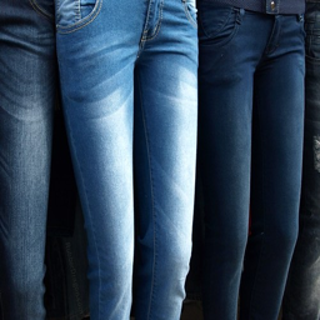

P2 ✗ missing: 002909_p2.png
OURS ✓ 002909_ours.png


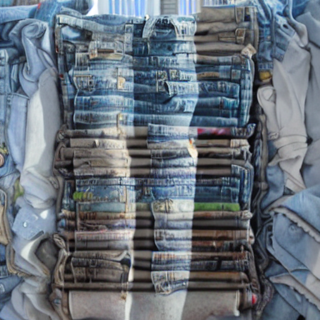

In [35]:
from pathlib import Path
from PIL import Image
from IPython.display import display

OUT_DIR = Path("/content/drive/MyDrive/transcreation_outputs")

def show_triplet(idx, size=320):
    src = OUT_DIR / f"{idx:06d}_src.png"
    p2  = OUT_DIR / f"{idx:06d}_p2.png"
    ours = OUT_DIR / f"{idx:06d}_ours.png"

    print("IDX:", idx)
    for label, path in [("SRC", src), ("P2", p2), ("OURS", ours)]:
        if path.exists():
            print(label, "✓", path.name)
            display(Image.open(path).convert("RGB").resize((size, size)))
        else:
            print(label, "✗ missing:", path.name)

# דוגמה:
show_triplet(2909)
